In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from utils import *

## Model Size

### Graph Compilation Not Cached

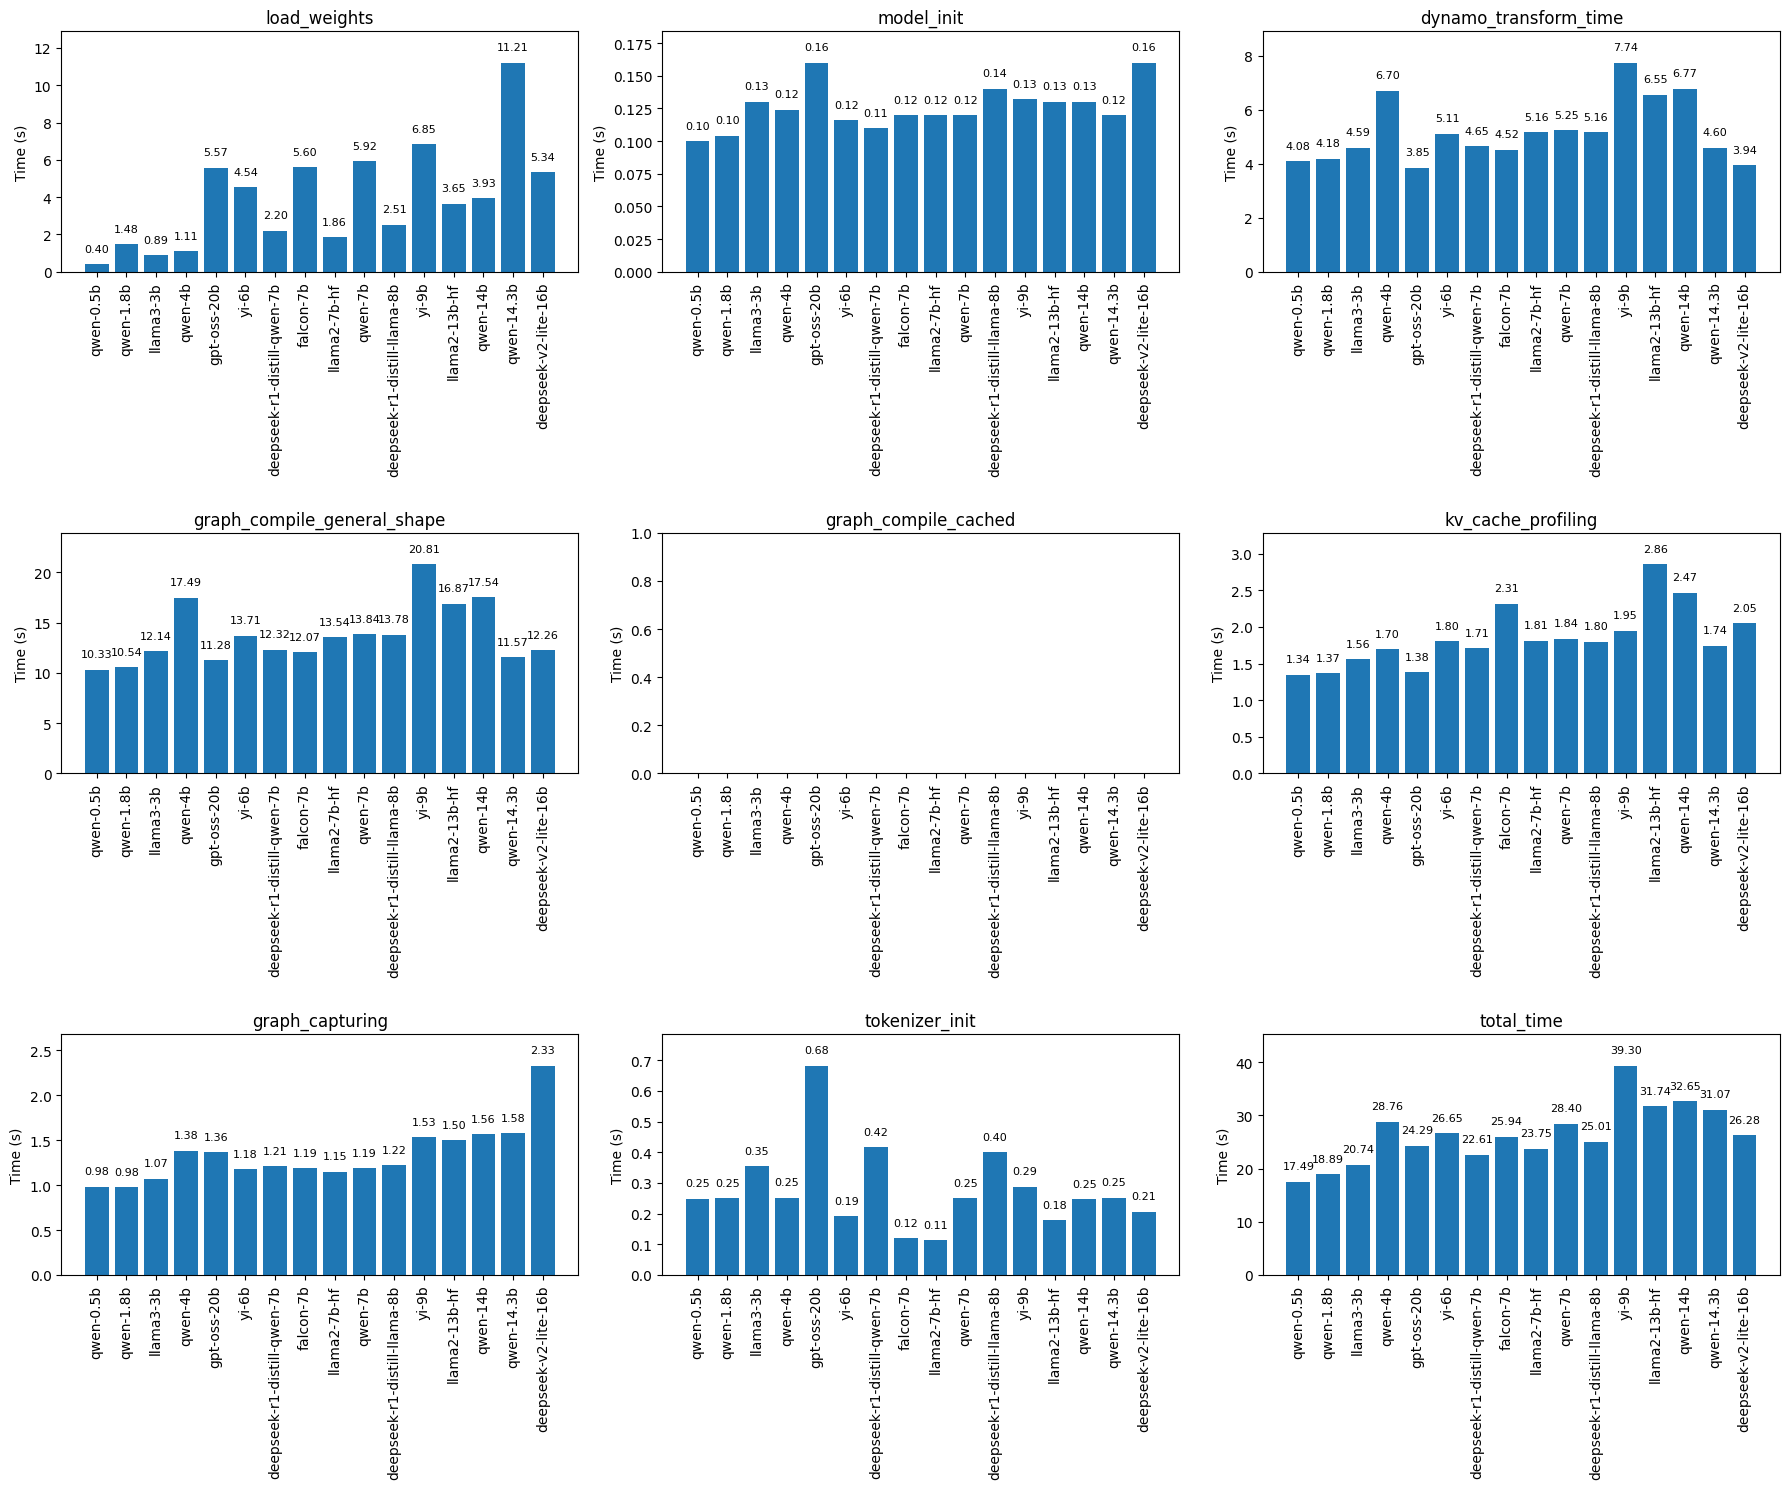

In [11]:
model_size_not_cached_json_filepath = "examples/uncached_graphs/avg_comparison_results.json"
draw_graph(model_size_not_cached_json_filepath, "model_size")

### Graph Compilation Cached

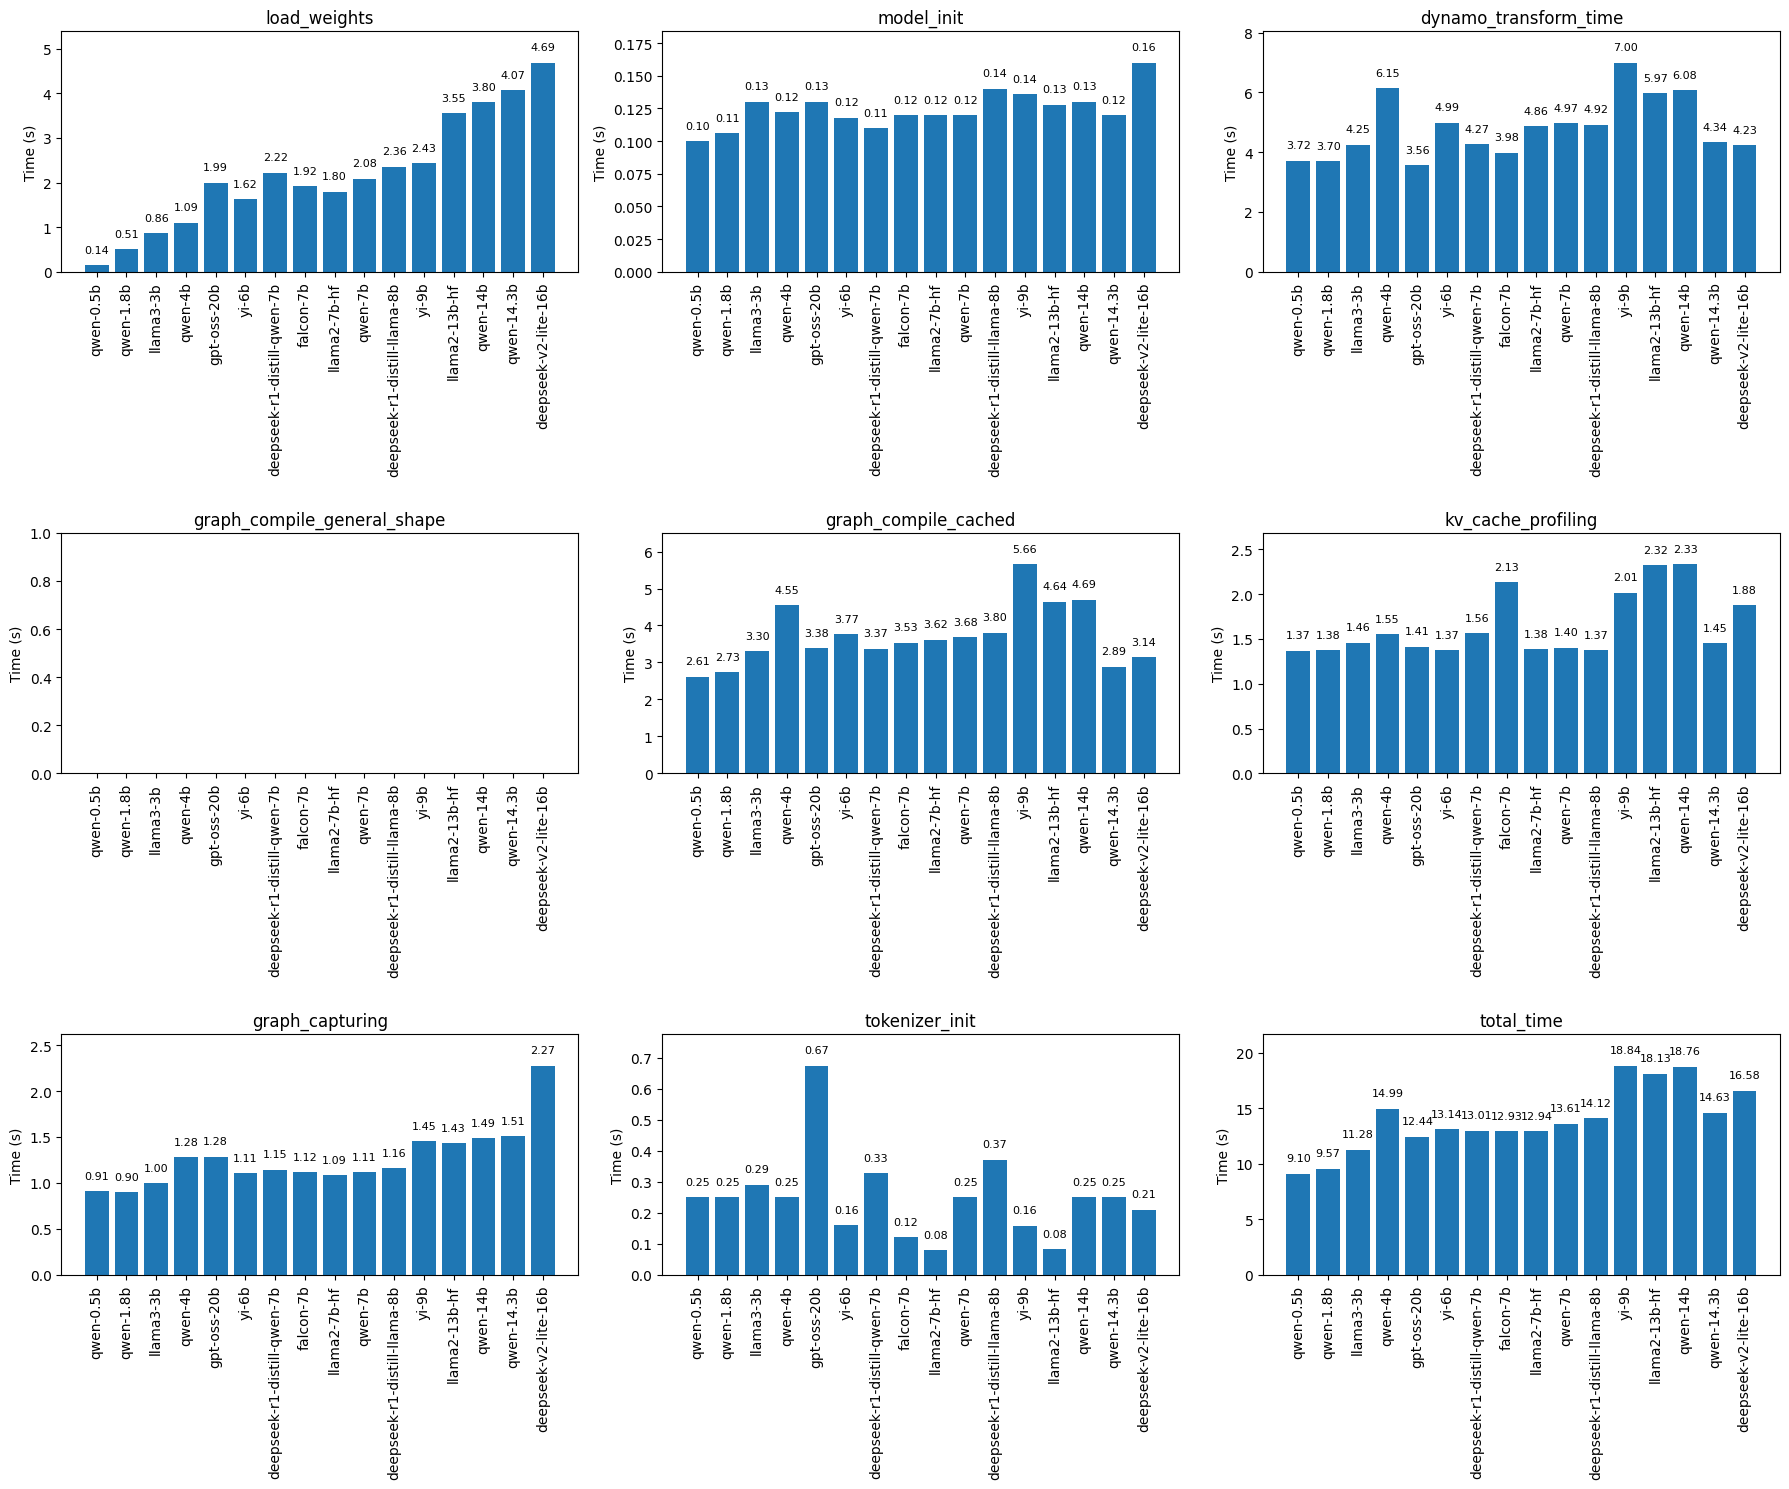

In [5]:
model_size_json_filepath = "examples/model_size/avg_comparison_results.json"
draw_graph(model_size_json_filepath, "model_size")

#### Relation between load_weights, graph_capturing and model size

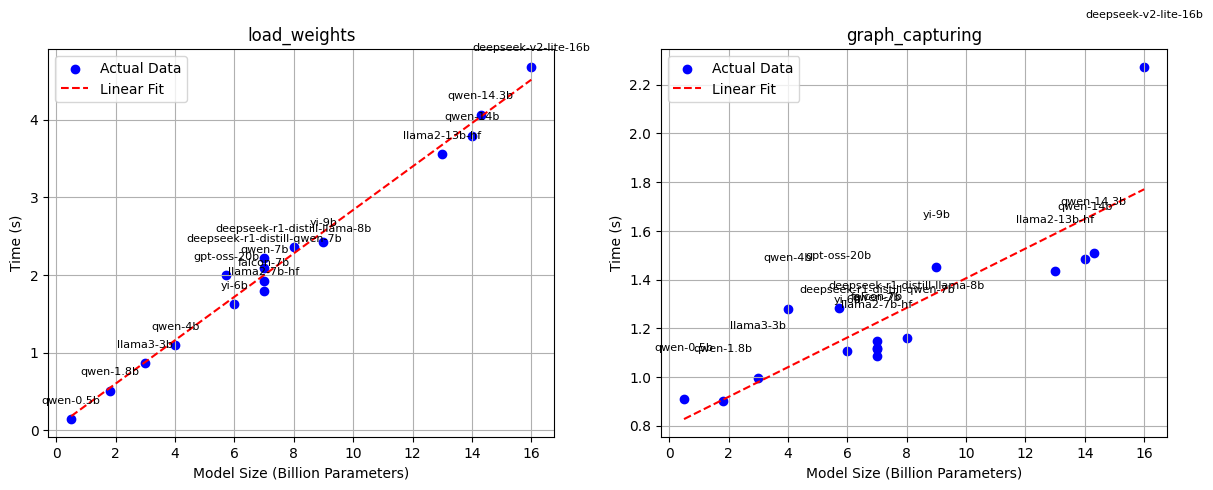

In [4]:
keys = ["load_weights", "graph_capturing"]
draw_relationship(model_size_json_filepath, "model_size", keys, "Model Size (Billion Parameters)", extract_model_size)

#### Relation between graph_compile_cached, dynamo_transform_time and nb_layers

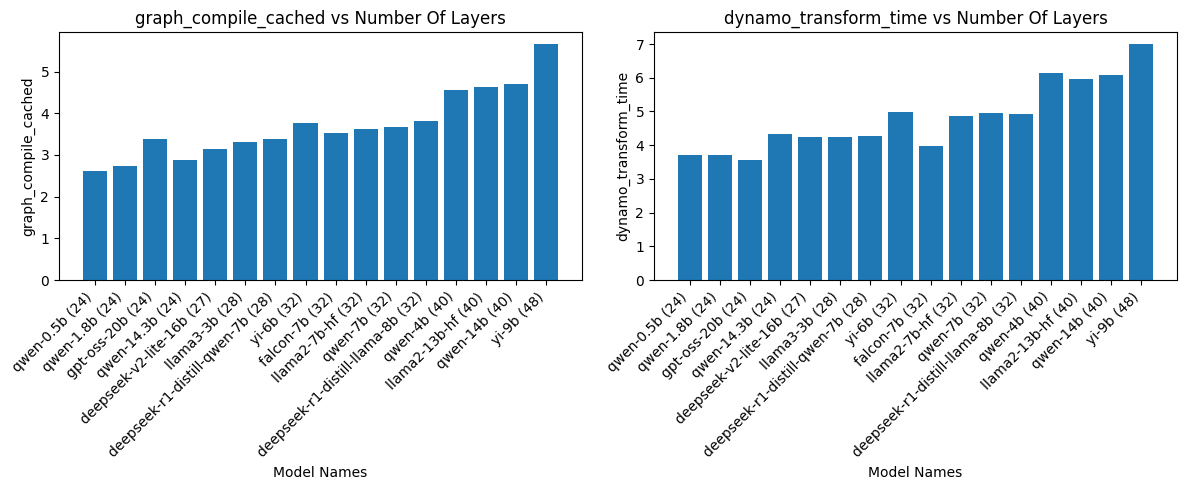

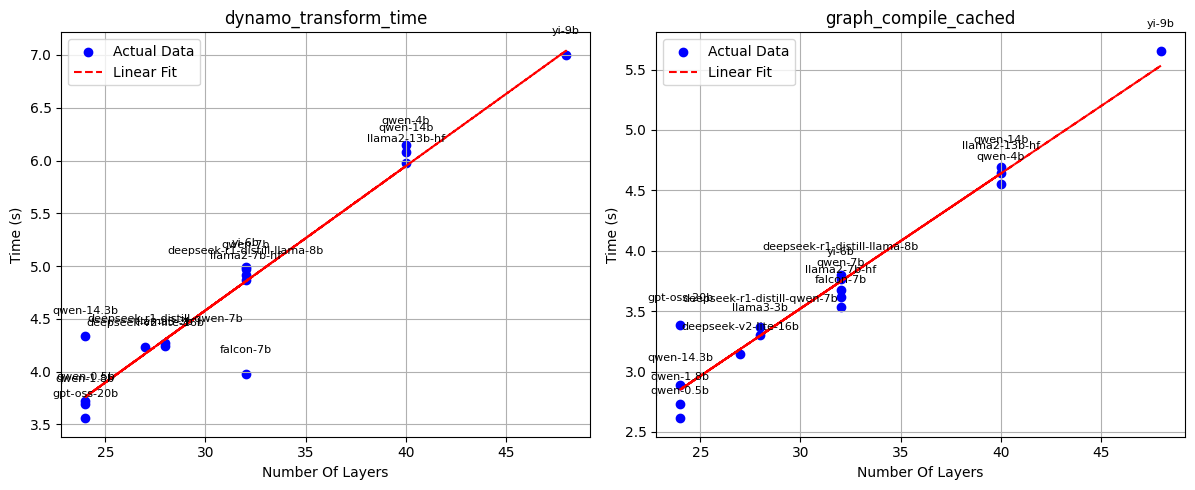

In [19]:
draw_metric_wrt_metric([
    {"json_filepath": model_size_json_filepath, "metric": "graph_compile_cached"},
    {"json_filepath": model_size_json_filepath, "metric": "dynamo_transform_time"},
    # {"json_filepath": model_size_not_cached_json_filepath, "metric": "graph_compile_general_shape"}
], {"key": "layers", "title": "Number Of Layers"})

keys = ["dynamo_transform_time", "graph_compile_cached"]
draw_relationship(model_size_json_filepath, "model_size", keys, "Number Of Layers", extract_nb_layers)

# keys = ["graph_compile_general_shape"]
# draw_relationship(model_size_not_cached_json_filepath, "model_size", keys, "Number Of Layers", extract_nb_layers)

#### Relation between kv_cache_profiling and ??

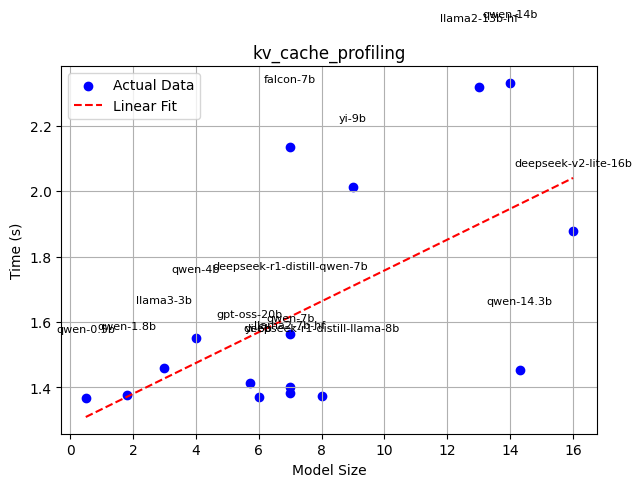

In [20]:
keys = ["kv_cache_profiling"]
draw_relationship(model_size_json_filepath, "model_size", keys, "Model Size", extract_model_size)

#### Relation between tokenizer_init_time and vocab_size

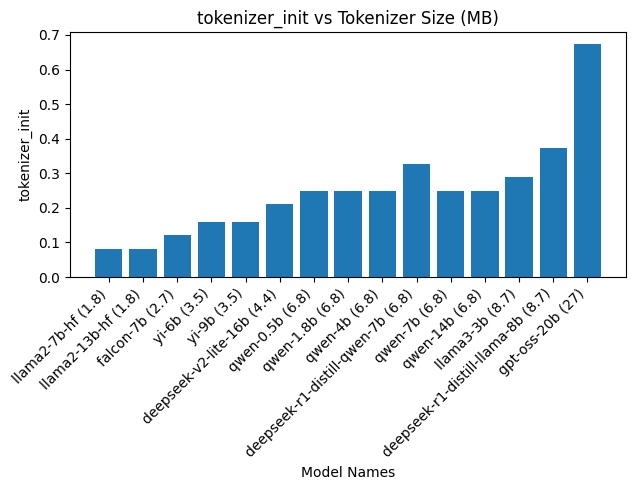

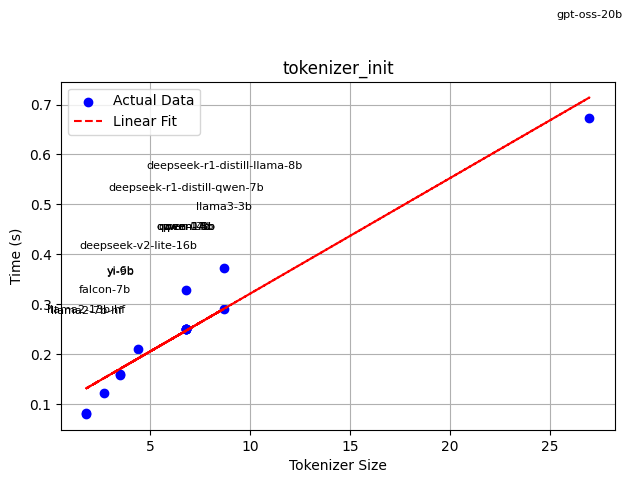

In [12]:
draw_metric_wrt_metric([{"json_filepath": model_size_json_filepath, "metric": "tokenizer_init"}], {"key": "tokenizer_size", "title": "Tokenizer Size (MB)"})
draw_relationship(model_size_json_filepath, "model_size", ["tokenizer_init"], "Tokenizer Size", extract_tokenizer_size)

# Batch Size

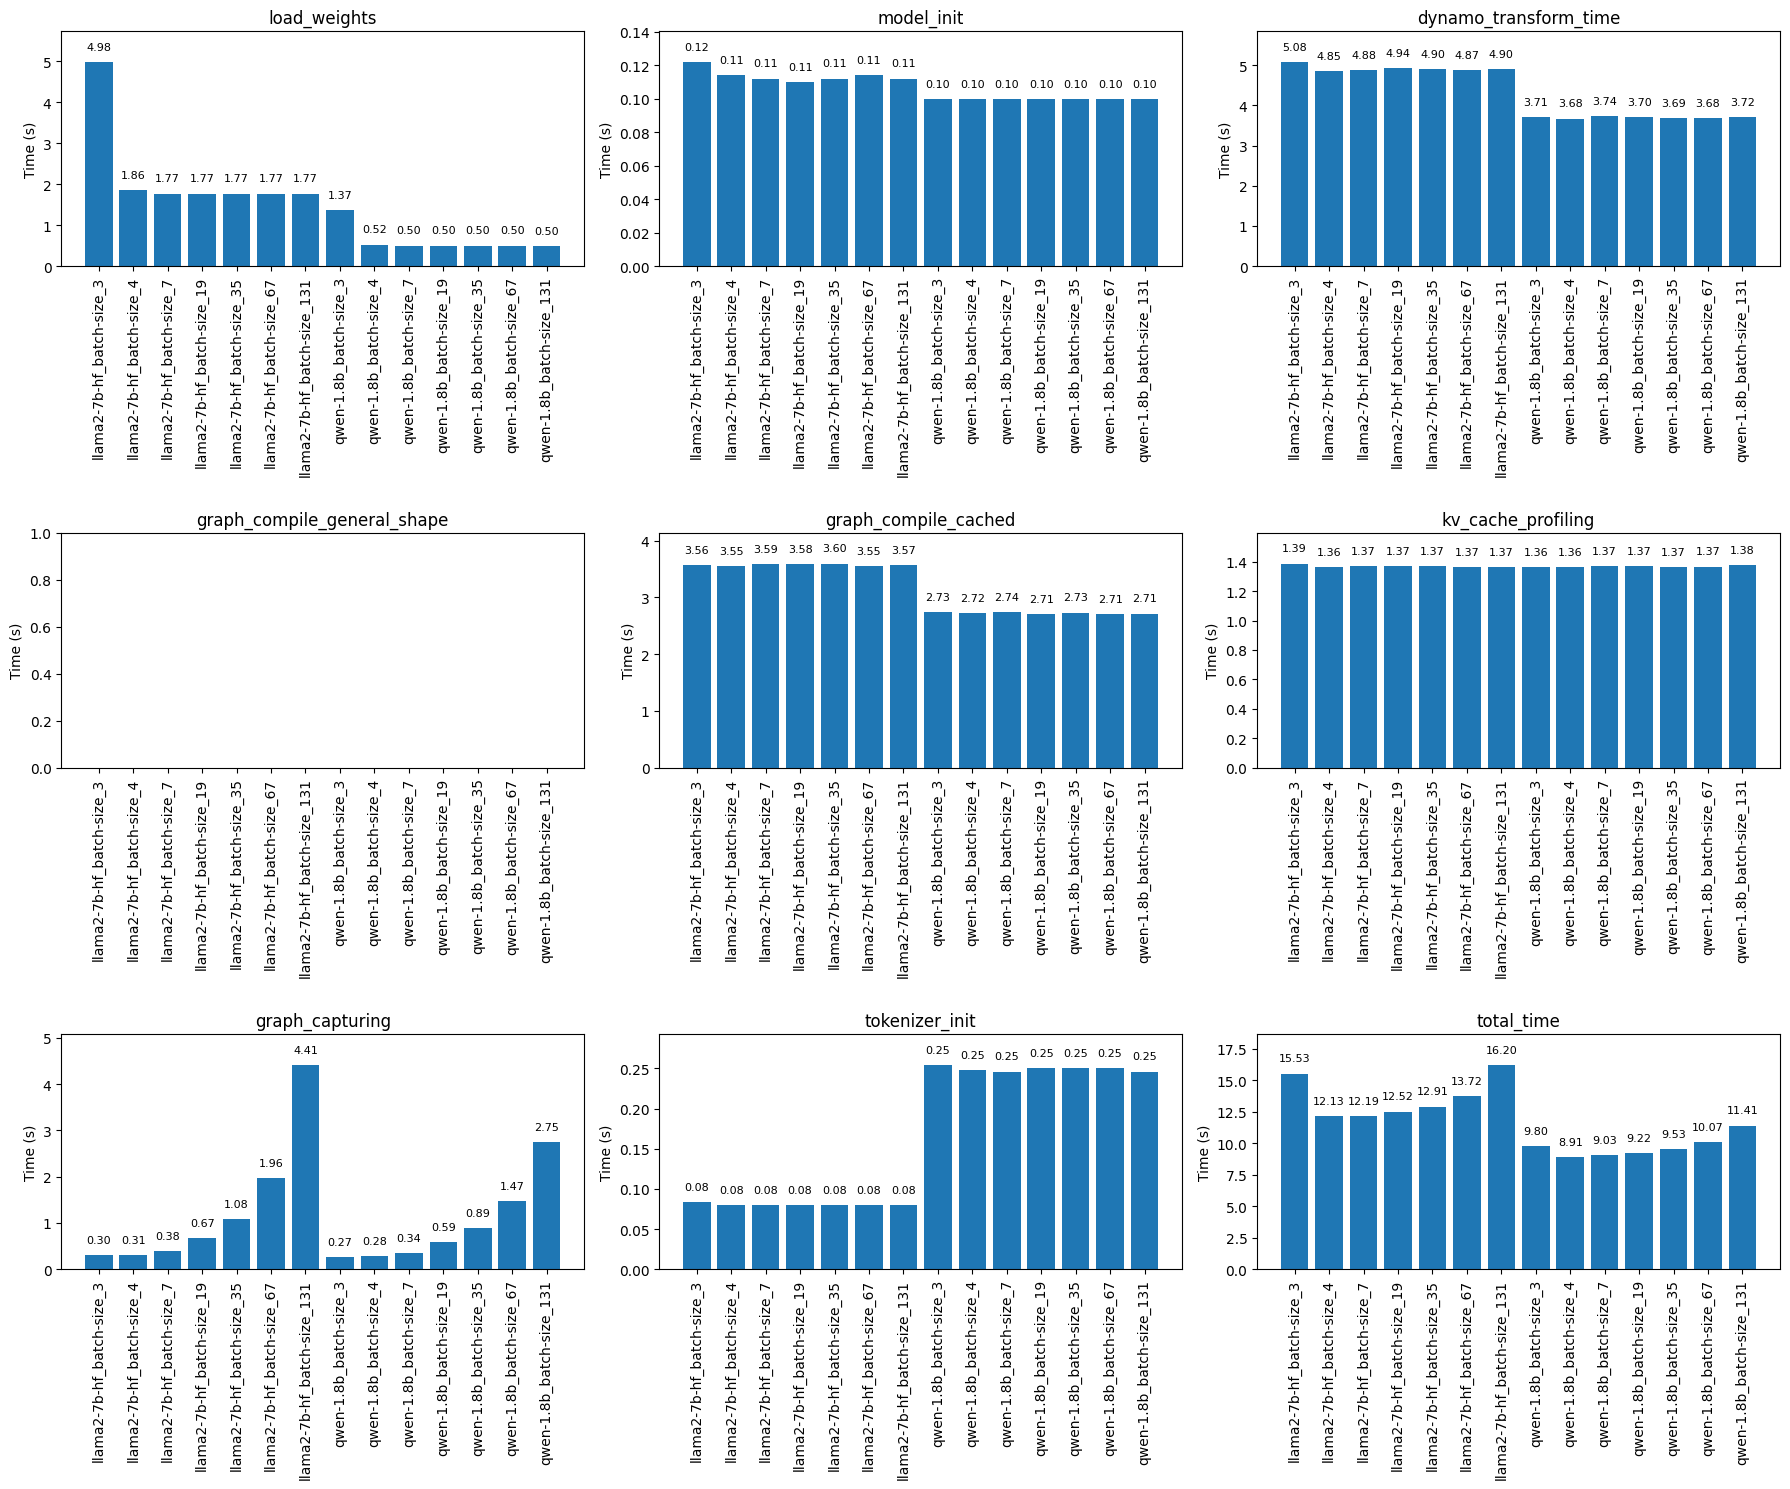

In [13]:
batch_size_json_filepath = "examples/batch_size/avg_comparison_results.json"
draw_graph(batch_size_json_filepath, "alphabetical")

### Relation between graph_capturing and batch_size * model_size

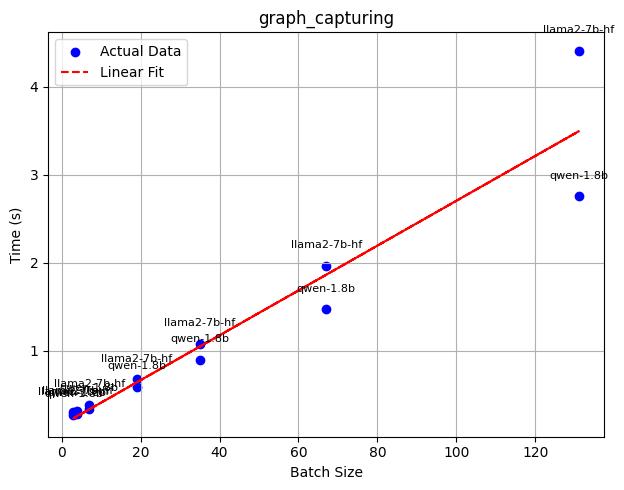

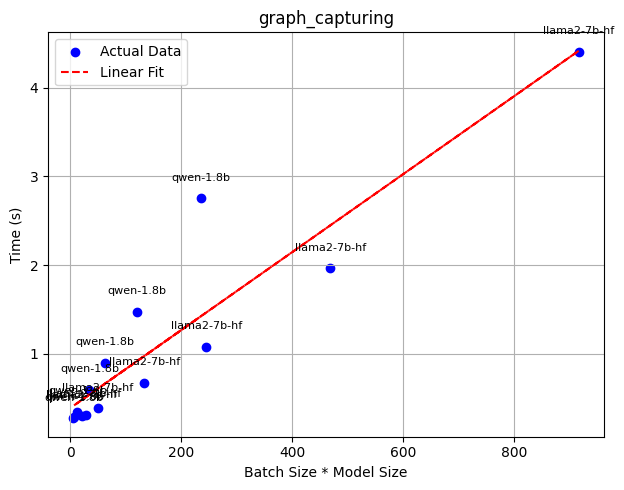

In [14]:
draw_relationship(batch_size_json_filepath, "alphabetical", ["graph_capturing"], "Batch Size", extract_batch_size)
draw_relationship(batch_size_json_filepath, "alphabetical", ["graph_capturing"], "Batch Size * Model Size", extract_batch_size_x_model_size)

# Quantization

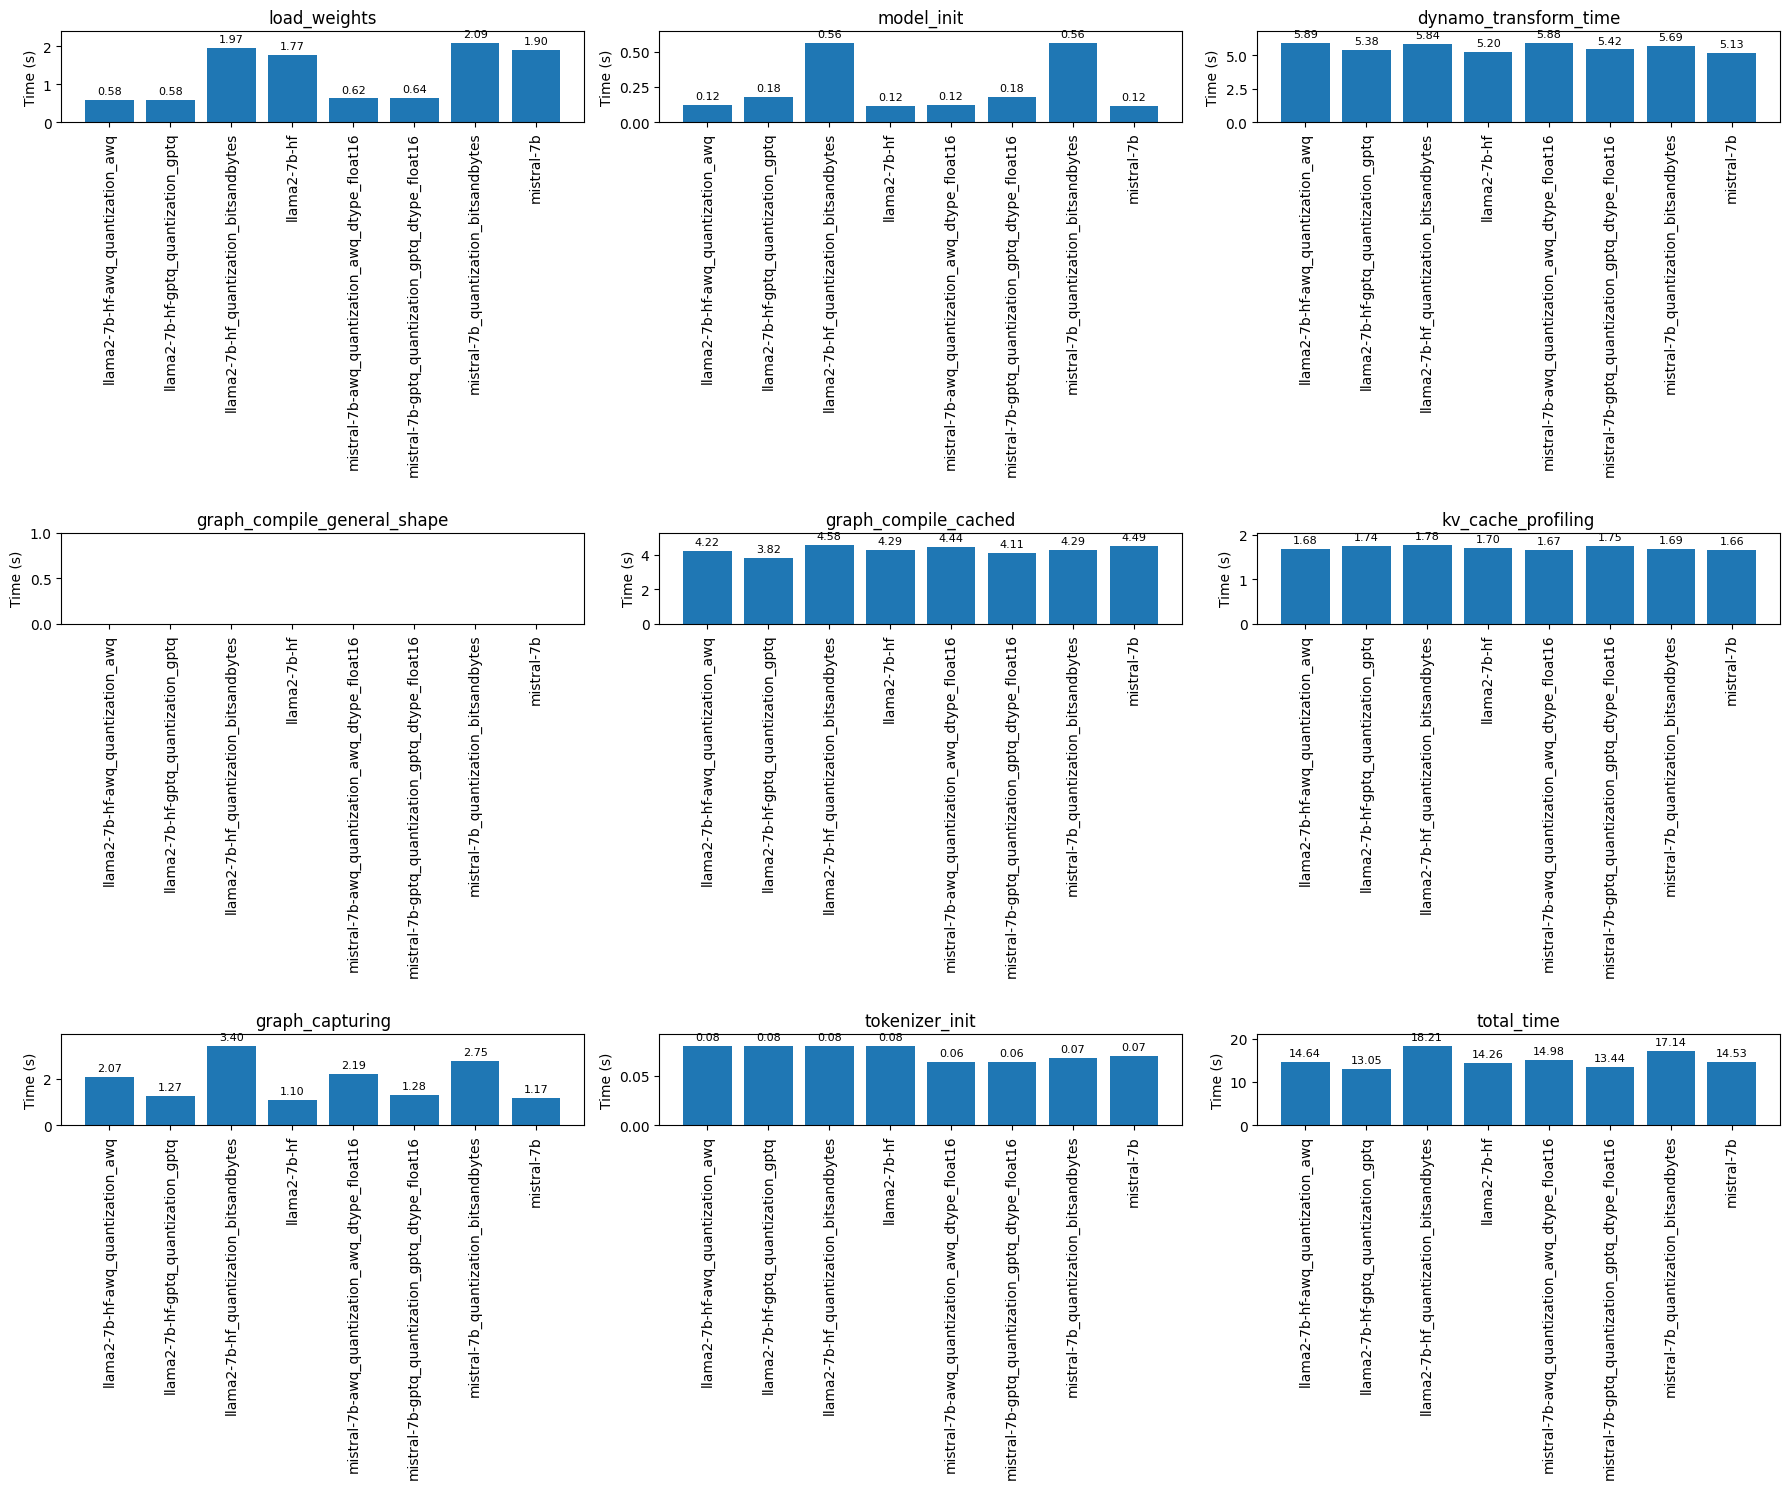

In [2]:
quantization_json_filepath = "examples/quantization/avg_comparison_results.json"
draw_graph(quantization_json_filepath, "model_size")

# Versions

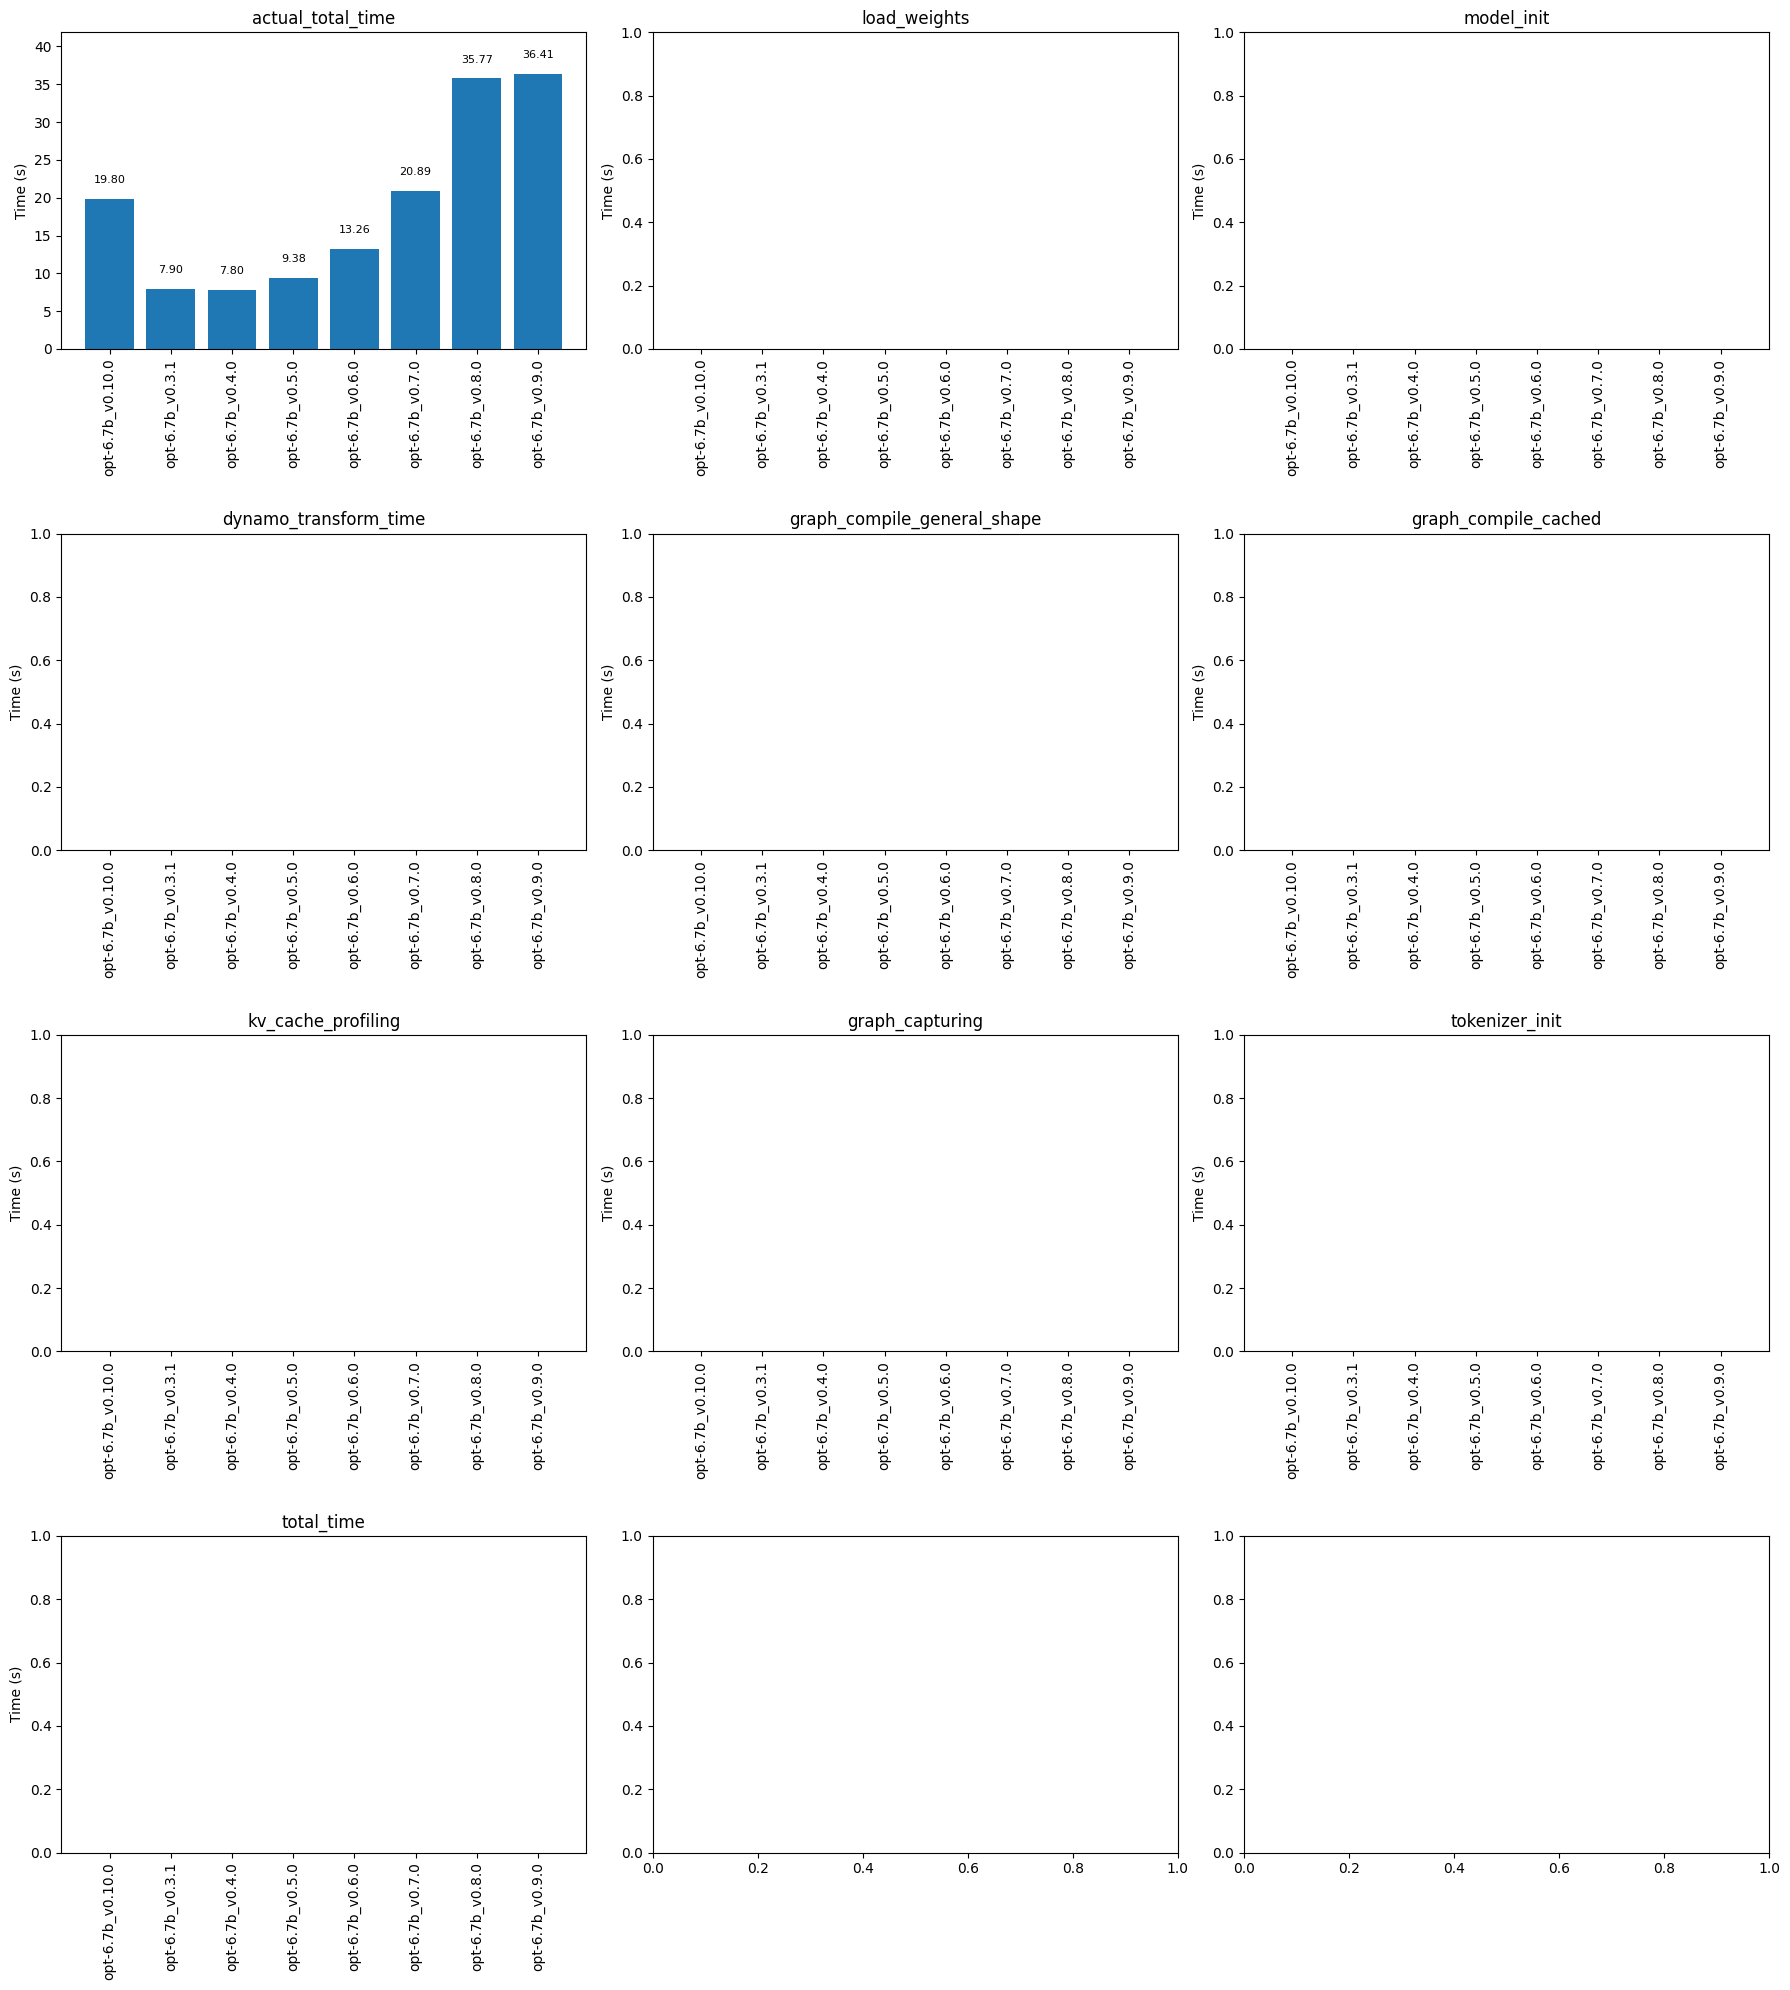

In [ ]:
versions_json_filepath = "examples/versions/avg_comparison_results.json"
draw_graph(versions_json_filepath, "version")

# Loading Methods

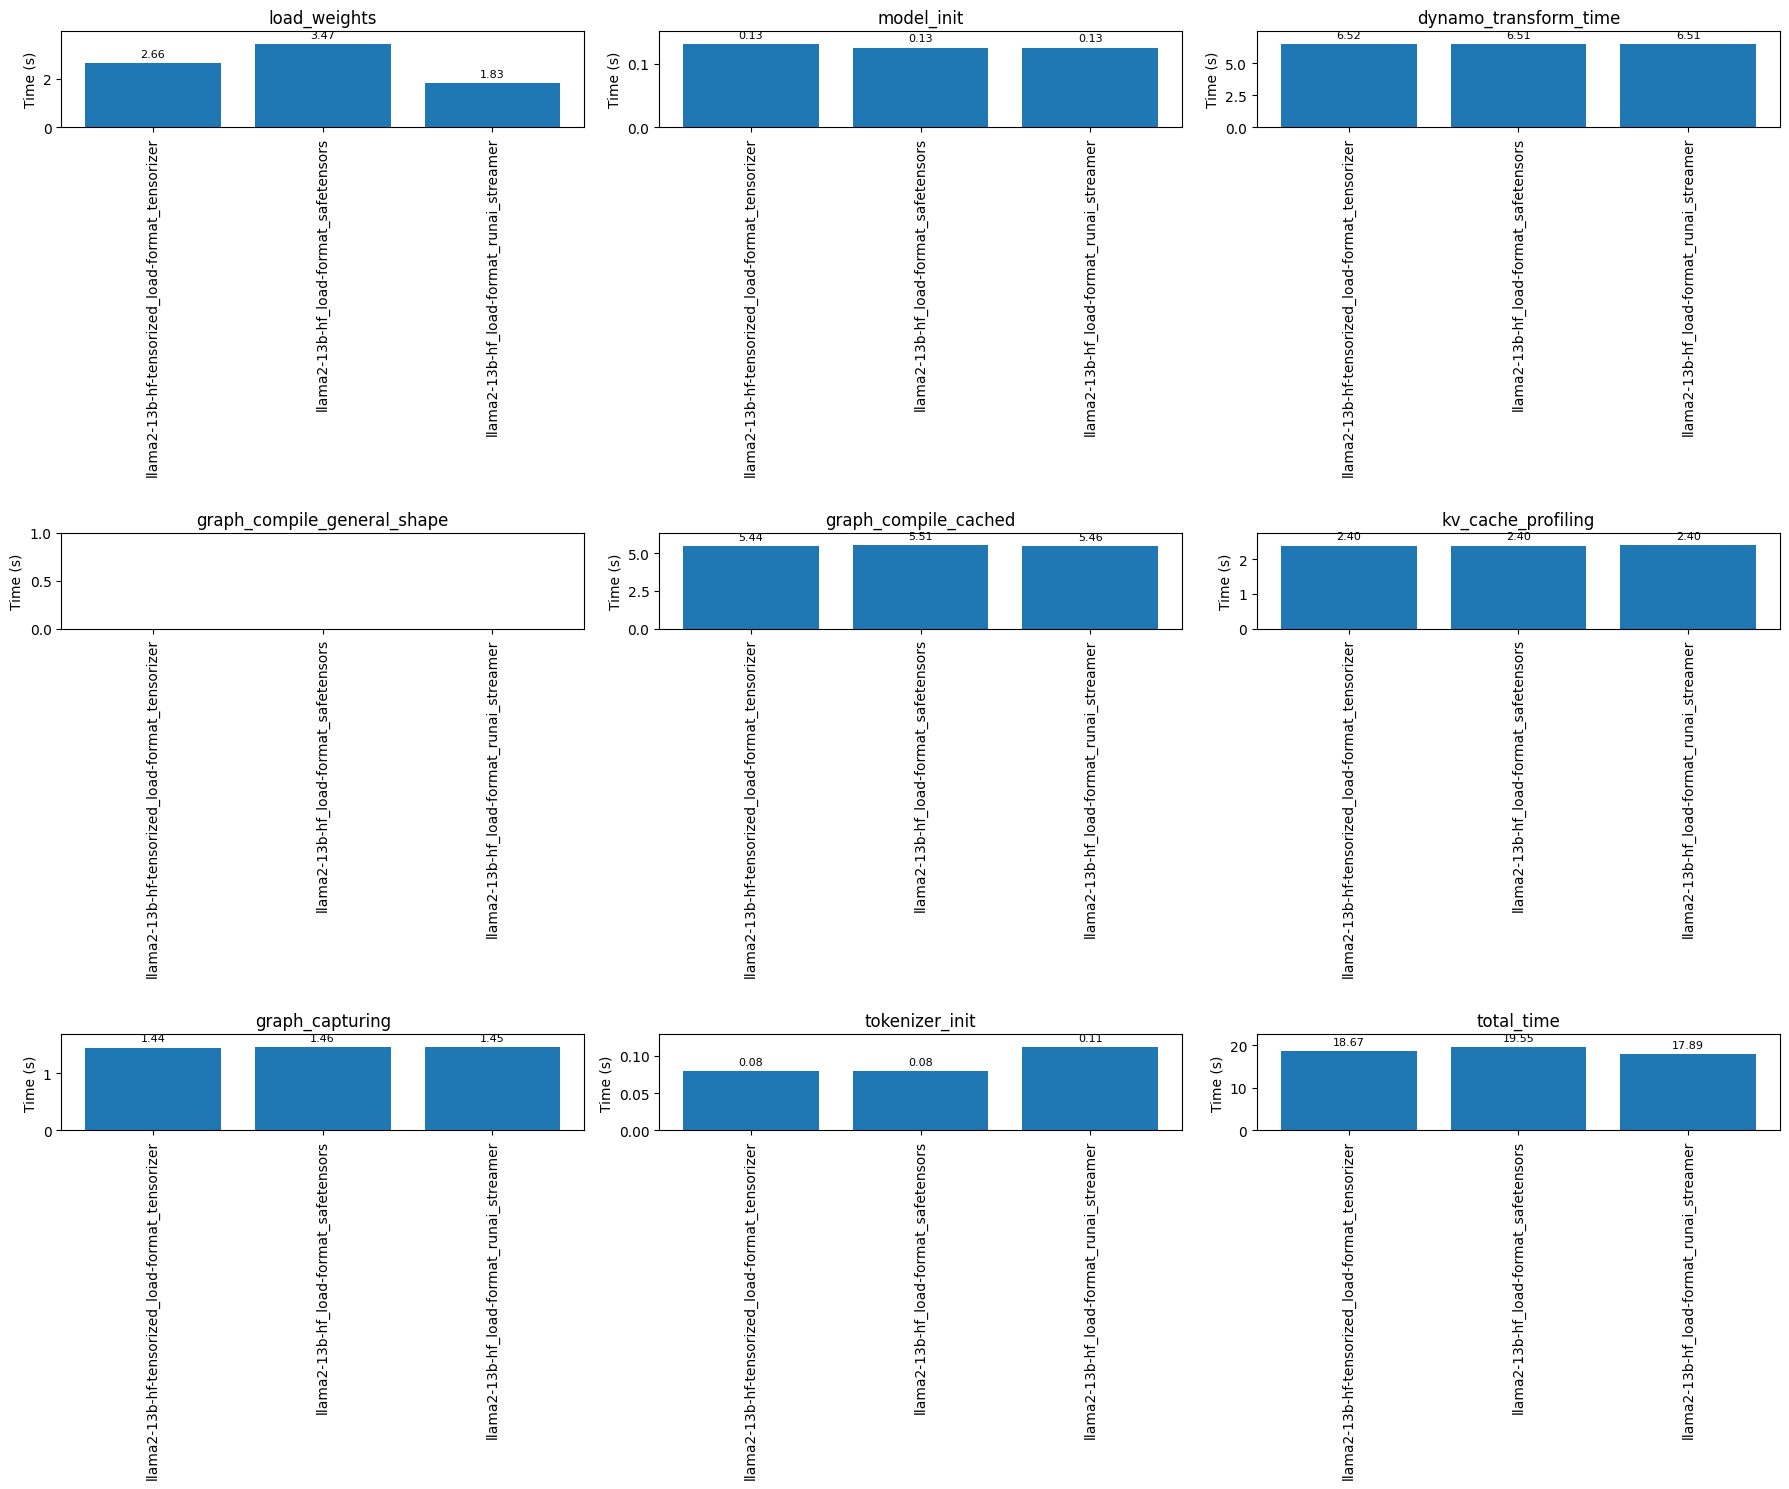

In [6]:
loading_methods_json_filepath = "examples/loading_methods/avg_comparison_results.json"
draw_graph(loading_methods_json_filepath, "model_size")

# tmpfs

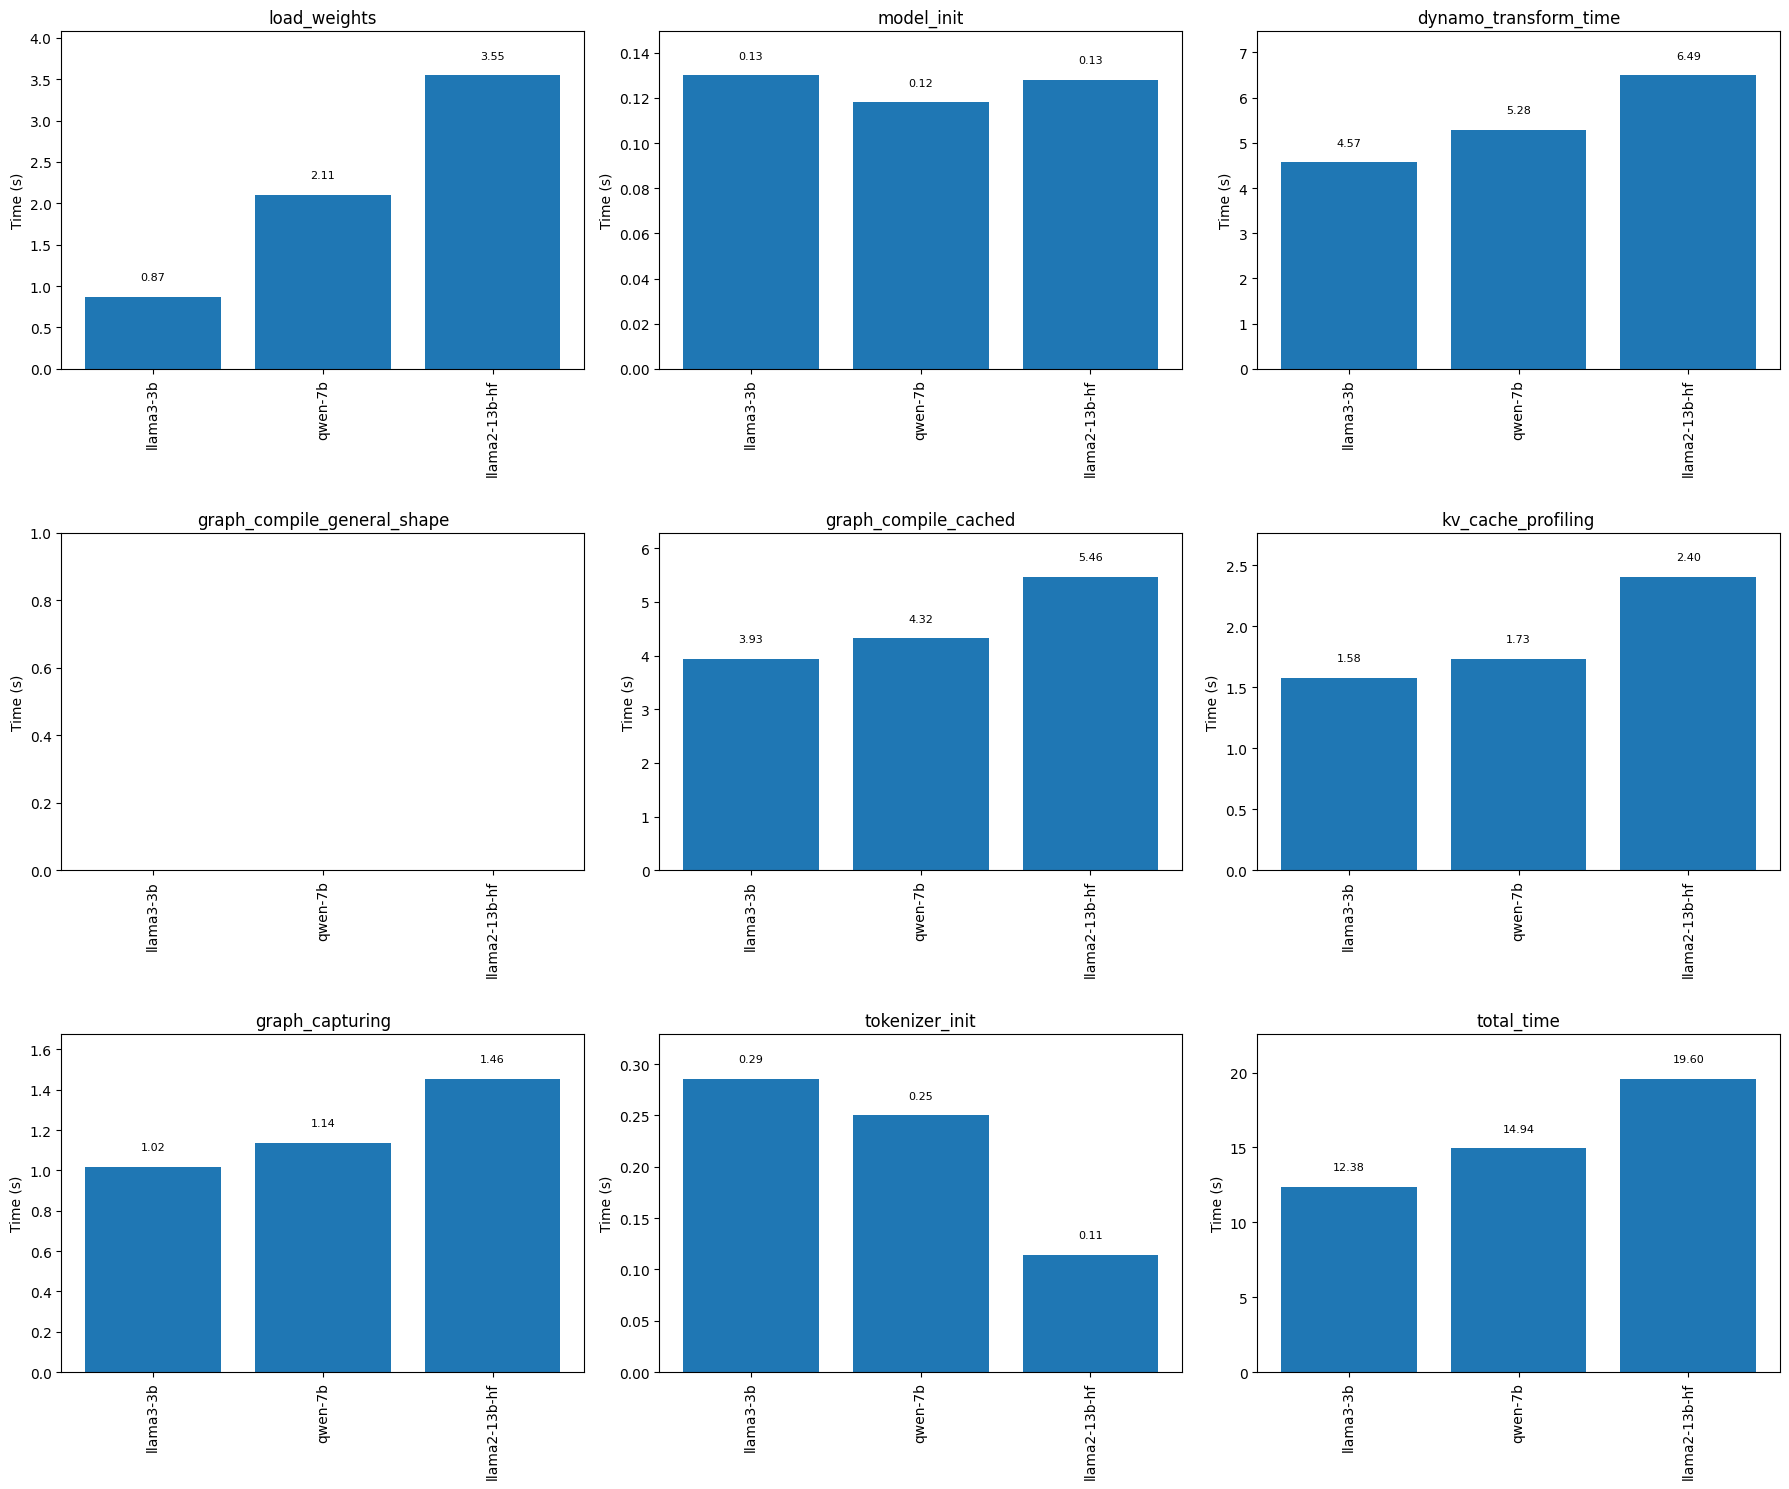

In [12]:
tmpfs_json_filepath = "examples/tmpfs/avg_comparison_results.json"
draw_graph(tmpfs_json_filepath, "model_size")